In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
import os
import joblib
import json

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense , Flatten, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import RandomSearch

from sklearn.metrics import confusion_matrix, classification_report

# Set directory
base_dir = './sets'
# Load validation set and test set
X_val = np.load(f'{base_dir}/X_val.npy')
y_val = np.load(f'{base_dir}/y_val.npy')
X_test = np.load(f'{base_dir}/X_test.npy')
y_test = np.load(f'{base_dir}/y_test.npy')

# load best sets
over_sampled_best_X_val = np.load(f'{base_dir}/over_sampled_best_X_val.npy')
under_sampled_best_X_val = np.load(f'{base_dir}/under_sampled_best_X_val.npy')
over_sampled_best_X_test = np.load(f'{base_dir}/over_sampled_best_X_test.npy')
under_sampled_best_X_test = np.load(f'{base_dir}/under_sampled_best_X_test.npy')

# make output directory
output_dir = './shallow_nn_out'
os.makedirs(output_dir, exist_ok=True)

n_features = X_val.shape[1]
n_best_over_features = over_sampled_best_X_val.shape[1]
n_best_under_features = under_sampled_best_X_val.shape[1]

2024-04-14 04:28:23.395525: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 04:28:24.173444: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_7790/1763327434.py:18: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Tuning hyperparameters 

In [2]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (200,)],  # Number of hidden units
    'activation': ['relu', 'tanh', 'logistic'],  # Activation function
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Regularization strength (L2 penalty)
    'learning_rate_init': [0.001, 0.01, 0.1],  # Initial learning rate
}    

In [3]:

def build_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_dim=n_features
    ))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

# Tunning to each specific set

## Under Sampling - No selection

In [4]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory=output_dir,
    project_name='under_no_sel_shallow_nn'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)



Reloading Tuner from ./shallow_nn_out/under_no_sel_shallow_nn/tuner0.json


2024-04-14 04:28:24.807588: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 04:28:24.830234: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 04:28:24.830564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
# training data
x_train = np.load(f'{base_dir}/under_sampled_X_train.npy')
y_train = np.load(f'{base_dir}/under_sampled_y_train.npy')
tuner.search(x_train, y_train, epochs=70, validation_data=(X_val, y_val), callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""Found:
- units: {best_hps.get('units')}
- activation: {best_hps.get('activation')}
- learning_rate: {best_hps.get('learning_rate')}
""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=70, validation_data=(X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/under_sampled_no_selection', exist_ok=True)
# Save the model
model.save(f'{output_dir}/under_sampled_no_selection/shallow_nn_model.h5')
# Save the history
with open(f'{output_dir}/under_sampled_no_selection/shallow_nn_history.json', 'w') as f:
    json.dump(history.history, f)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
#save the test loss and accuracy
with open(f'{output_dir}/under_sampled_no_selection/shallow_nn_test_loss_accuracy.txt', 'w') as f:
    f.write(f'Test loss: {test_loss}\nTest accuracy: {test_acc}\n')



Found:
- units: 128
- activation: sigmoid
- learning_rate: 0.001

Epoch 1/70


/home/leikrad/Projects/TAA/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


I0000 00:00:1713065305.452513    7888 service.cc:145] XLA service 0x7b0ce0004400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713065305.452537    7888 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-04-14 04:28:25.468616: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-14 04:28:25.546939: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 1/14 ━━━━━━━━━━━━━━━━━━━━ 9s 745ms/step - accuracy: 0.5000 - loss: 0.7699

I0000 00:00:1713065305.759235    7888 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.6258 - loss: 0.6636 - val_accuracy: 0.9765 - val_loss: 0.5154
Epoch 2/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.8976 - loss: 0.4468 - val_accuracy: 0.9862 - val_loss: 0.4359
Epoch 3/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8946 - loss: 0.3534 - val_accuracy: 0.9944 - val_loss: 0.3075
Epoch 4/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.8705 - loss: 0.3271 - val_accuracy: 0.9960 - val_loss: 0.2490
Epoch 5/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9332 - loss: 0.2354 - val_accuracy: 0.9969 - val_loss: 0.2110
Epoch 6/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9192 - loss: 0.2452 - val_accuracy: 0.9937 - val_loss: 0.2128
Epoch 7/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9247 - loss: 0.2192 - val_accuracy: 0.9919 - val_loss: 0.1952
Epoch 8/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9295 - loss: 0.2122 - val_accuracy: 0.9908 - val_loss: 0.

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 634us/step - accuracy: 0.9699 - loss: 0.1281


# Plot of Training and Validation Accuracy/Loss

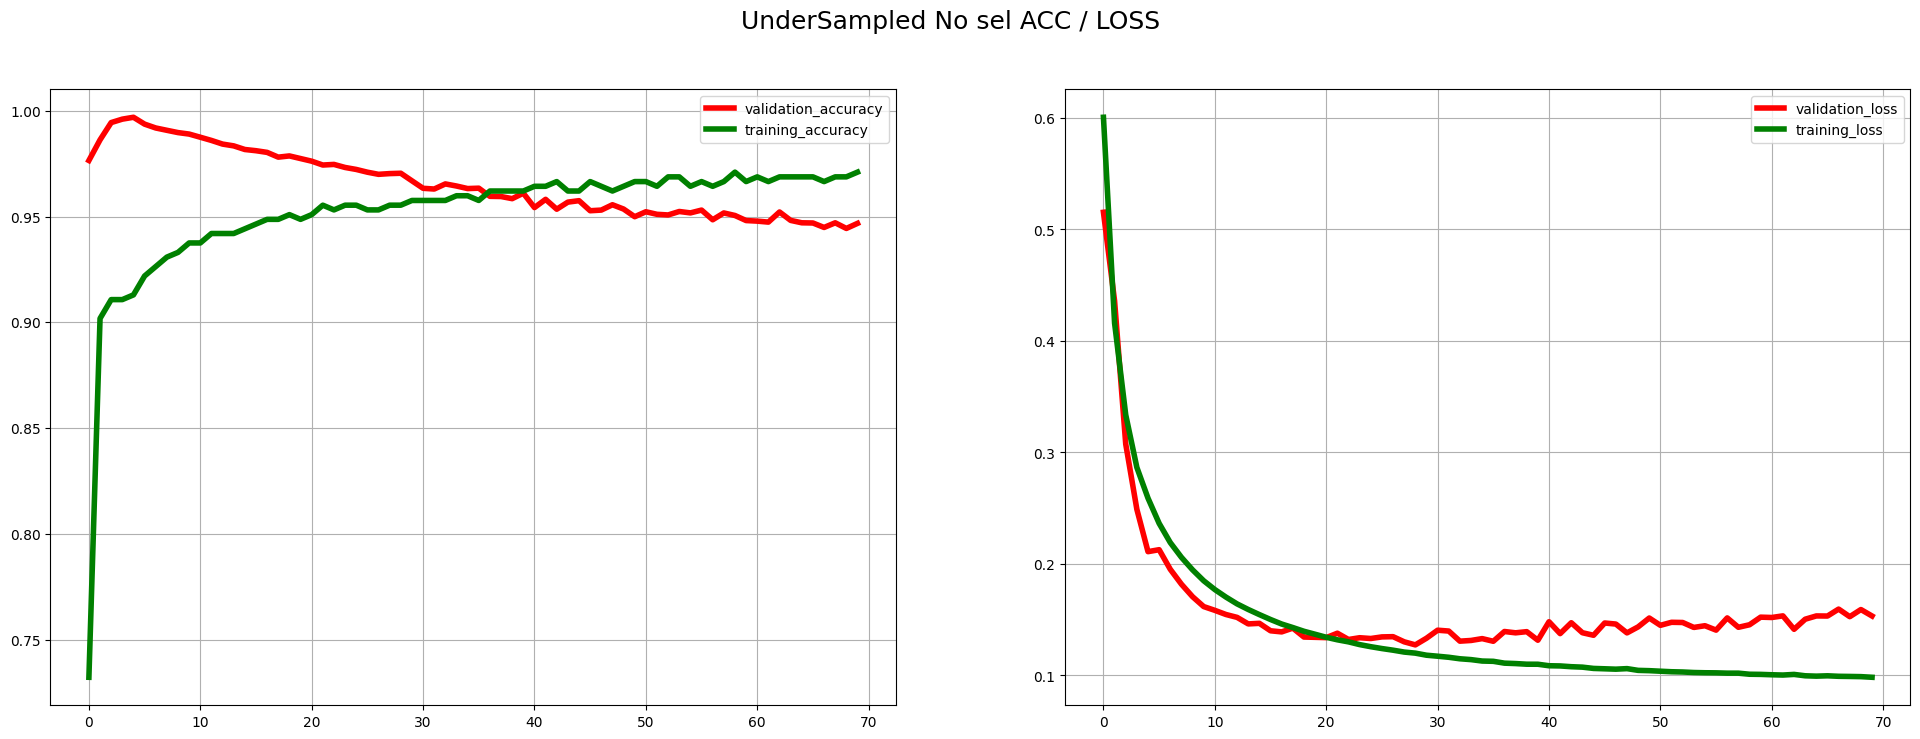

In [6]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(history.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(history.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.suptitle("UnderSampled No sel ACC / LOSS",fontsize=18)

plt.show()

# Confusion Matrix

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 532us/step
[[96539  2972]
 [   20   152]]
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98     99511
         1.0       0.05      0.88      0.09       172

    accuracy                           0.97     99683
   macro avg       0.52      0.93      0.54     99683
weighted avg       1.00      0.97      0.98     99683



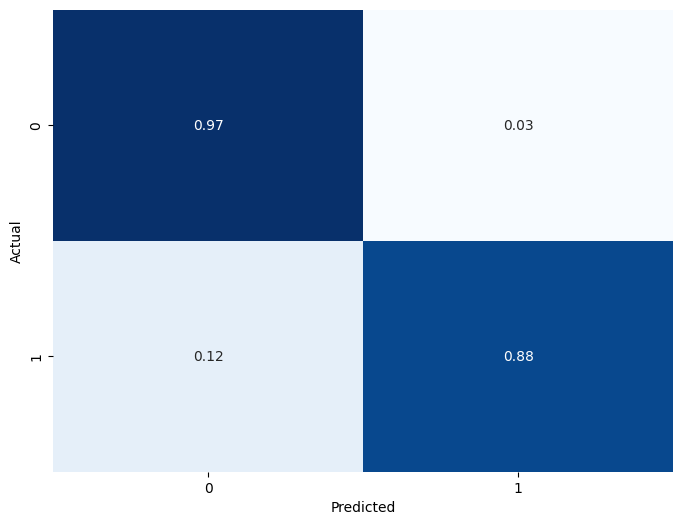

In [7]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Over Sampling - No selection

In [8]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory=output_dir,
    project_name='over_no_sel_shallow_nn'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)



Reloading Tuner from ./shallow_nn_out/over_no_sel_shallow_nn/tuner0.json


In [9]:
# training data
x_train = np.load(f'{base_dir}/over_sampled_X_train.npy')
y_train = np.load(f'{base_dir}/over_sampled_y_train.npy')
tuner.search(x_train, y_train, epochs=70, validation_data=(X_val, y_val), callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""Found:
- units: {best_hps.get('units')}
- activation: {best_hps.get('activation')}
- learning_rate: {best_hps.get('learning_rate')}
""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=70, validation_data=(X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/over_sampled_no_selection', exist_ok=True)
# Save the model
model.save(f'{output_dir}/over_sampled_no_selection/shallow_nn_model.h5')
# Save the history
with open(f'{output_dir}/over_sampled_no_selection/shallow_nn_history.json', 'w') as f:
    json.dump(history.history, f)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
#save the test loss and accuracy
with open(f'{output_dir}/over_sampled_no_selection/shallow_nn_test_loss_accuracy.txt', 'w') as f:
    f.write(f'Test loss: {test_loss}\nTest accuracy: {test_acc}\n')



Found:
- units: 224
- activation: relu
- learning_rate: 0.01

Epoch 1/70


/home/leikrad/Projects/TAA/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 815us/step - accuracy: 0.9901 - loss: 0.0392 - val_accuracy: 0.9985 - val_loss: 0.0107
Epoch 2/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 773us/step - accuracy: 0.9985 - loss: 0.0103 - val_accuracy: 0.9991 - val_loss: 0.0121
Epoch 3/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 760us/step - accuracy: 0.9989 - loss: 0.0086 - val_accuracy: 0.9989 - val_loss: 0.0145
Epoch 4/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 749us/step - accuracy: 0.9992 - loss: 0.0059 - val_accuracy: 0.9992 - val_loss: 0.0155
Epoch 5/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 790us/step - accuracy: 0.9995 - loss: 0.0051 - val_accuracy: 0.9994 - val_loss: 0.0143
Epoch 6/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 775us/step - accuracy: 0.9994 - loss: 0.0049 - val_accuracy: 0.9991 - val_loss: 0.0169
Epoch 7/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 772us/step - accuracy: 0.9992 - loss: 0.0094 - val_accuracy: 0.9992 - val_loss: 0.0219
Epoch 8/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 772us/step - accuracy: 0.9996 - loss: 0.00

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 634us/step - accuracy: 0.9980 - loss: 0.0214


# Plot of Training and Validation Accuracy/Loss

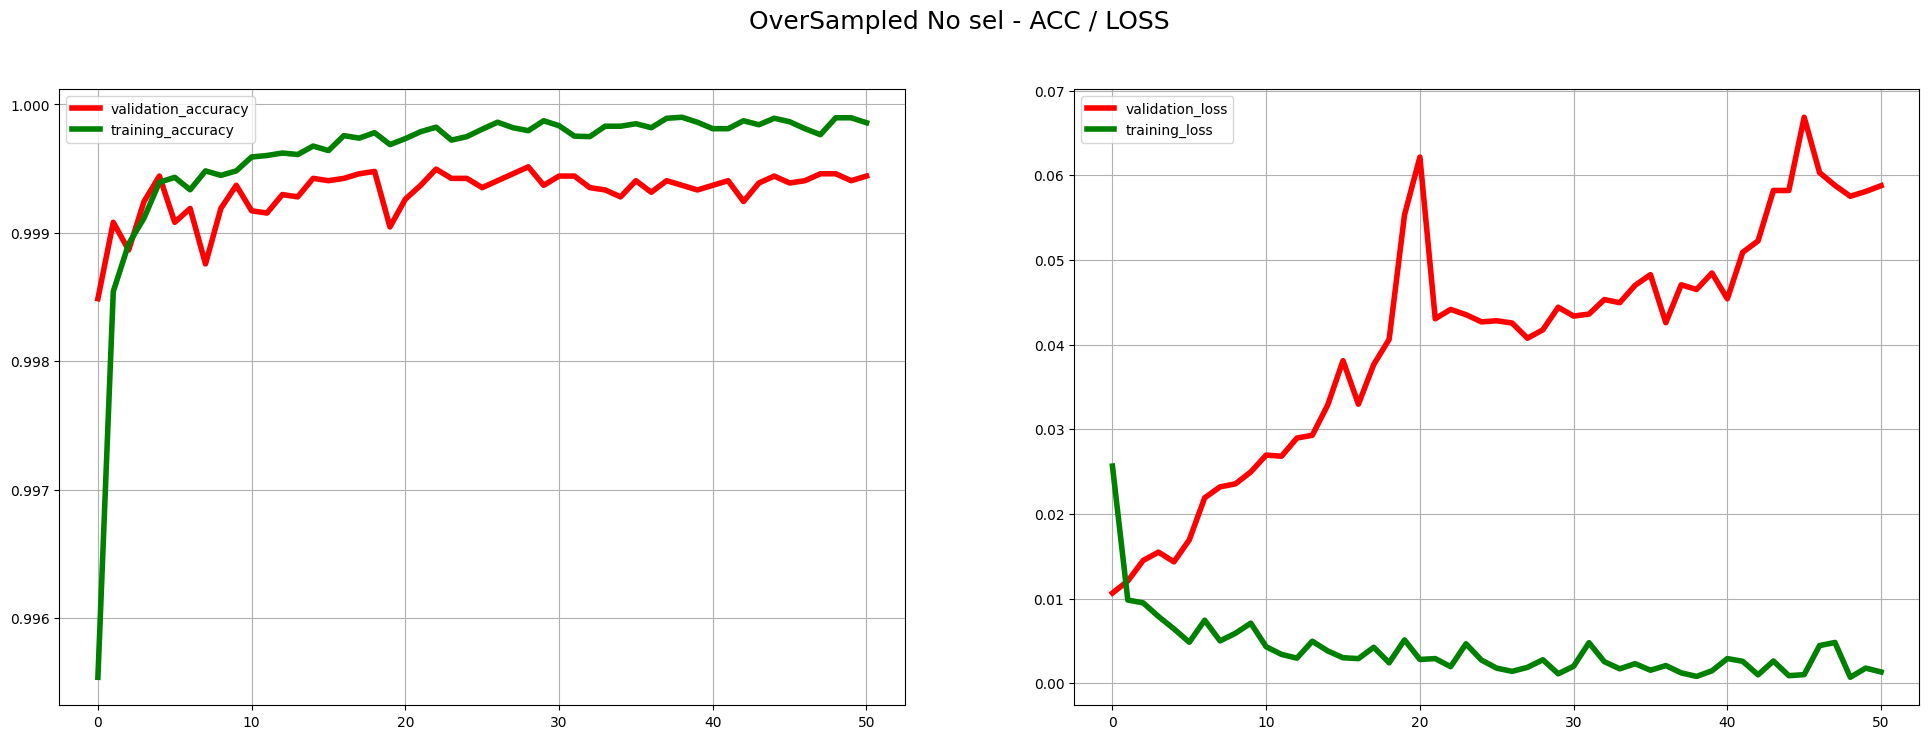

In [10]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(history.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(history.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.suptitle("OverSampled No sel - ACC / LOSS",fontsize=18)

plt.show()

# Confusion Matrix

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 532us/step
[[99311   200]
 [   31   141]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99511
         1.0       0.41      0.82      0.55       172

    accuracy                           1.00     99683
   macro avg       0.71      0.91      0.77     99683
weighted avg       1.00      1.00      1.00     99683



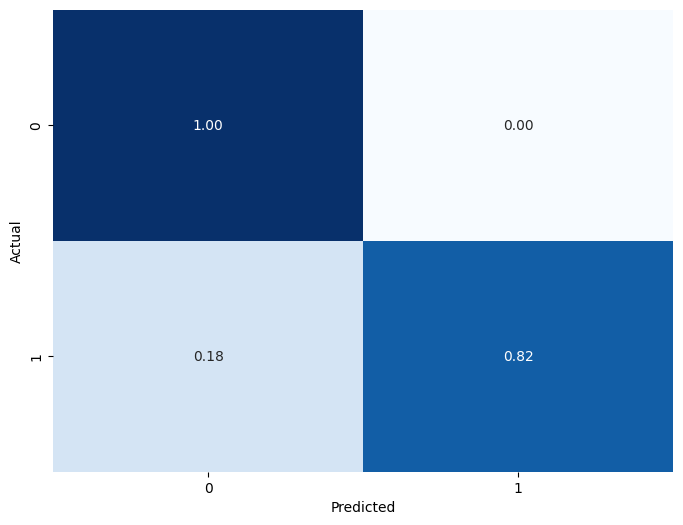

In [11]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# New builder

In [12]:

def build_best_under_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_dim=n_best_under_features
    ))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_best_under_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory=output_dir,
    project_name='under_best_sel_shallow_nn'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

Reloading Tuner from ./shallow_nn_out/under_best_sel_shallow_nn/tuner0.json


## Under Sampling - Best selection

In [13]:
# training data
x_train = np.load(f'{base_dir}/under_sampled_best_X_train.npy')
y_train = np.load(f'{base_dir}/under_sampled_y_train.npy')

tuner.search(x_train, y_train, epochs=70, validation_data=(under_sampled_best_X_val, y_val), callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""Found:
- units: {best_hps.get('units')}
- activation: {best_hps.get('activation')}
- learning_rate: {best_hps.get('learning_rate')}
""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=70, validation_data=(under_sampled_best_X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/under_sampled_best_selection', exist_ok=True)
# Save the model
model.save(f'{output_dir}/under_sampled_best_selection/shallow_nn_model.h5')
# Save the history
with open(f'{output_dir}/under_sampled_best_selection/shallow_nn_history.json', 'w') as f:
    json.dump(history.history, f)

# Evaluate the model
test_loss, test_acc = model.evaluate(under_sampled_best_X_test, y_test)
#save the test loss and accuracy
with open(f'{output_dir}/under_sampled_best_selection/shallow_nn_test_loss_accuracy.txt', 'w') as f:
    f.write(f'Test loss: {test_loss}\nTest accuracy: {test_acc}\n')



Found:
- units: 256
- activation: sigmoid
- learning_rate: 0.001

Epoch 1/70


/home/leikrad/Projects/TAA/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.4330 - loss: 0.6615 - val_accuracy: 0.9982 - val_loss: 0.4858
Epoch 2/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9165 - loss: 0.3587 - val_accuracy: 0.9991 - val_loss: 0.2484
Epoch 3/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.8913 - loss: 0.2957 - val_accuracy: 0.9989 - val_loss: 0.2259
Epoch 4/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.8740 - loss: 0.2805 - val_accuracy: 0.9988 - val_loss: 0.1907
Epoch 5/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9129 - loss: 0.2299 - val_accuracy: 0.9976 - val_loss: 0.1706
Epoch 6/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9143 - loss: 0.2267 - val_accuracy: 0.9934 - val_loss: 0.1698
Epoch 7/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9154 - loss: 0.2091 - val_accuracy: 0.9912 - val_loss: 0.1692
Epoch 8/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9268 - loss: 0.1901 - val_accuracy: 0.9911 - val_loss: 0.

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 618us/step - accuracy: 0.9869 - loss: 0.1294


# Plot of Training and Validation Accuracy/Loss

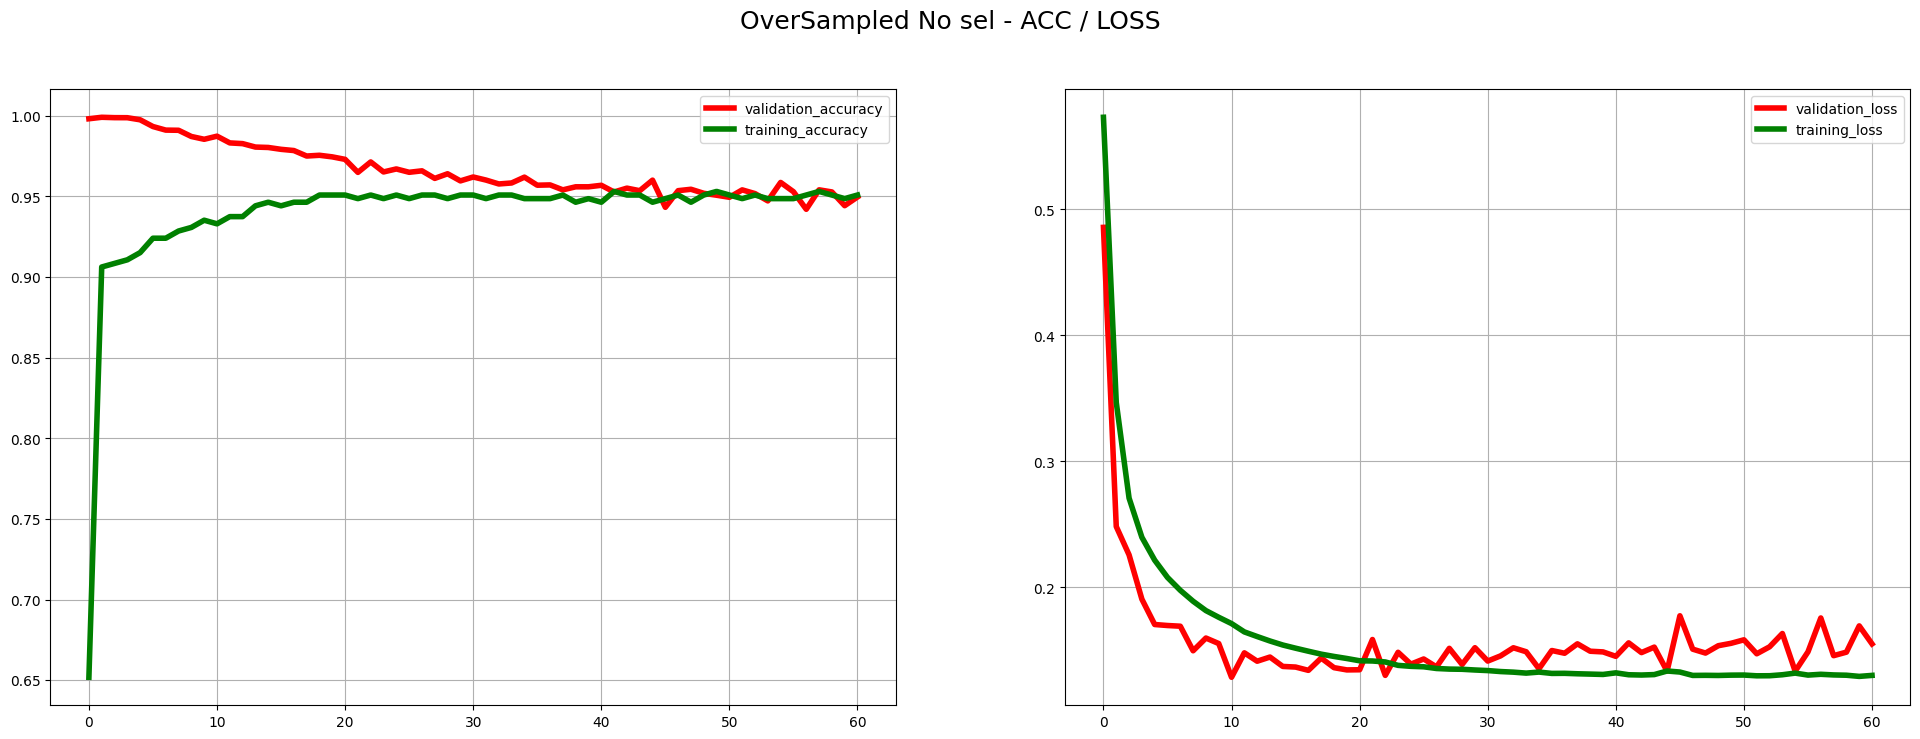

In [14]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(history.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(history.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.suptitle("OverSampled No sel - ACC / LOSS",fontsize=18)

plt.show()

# Confusion Matrix

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 541us/step
[[98238  1273]
 [   25   147]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     99511
         1.0       0.10      0.85      0.18       172

    accuracy                           0.99     99683
   macro avg       0.55      0.92      0.59     99683
weighted avg       1.00      0.99      0.99     99683



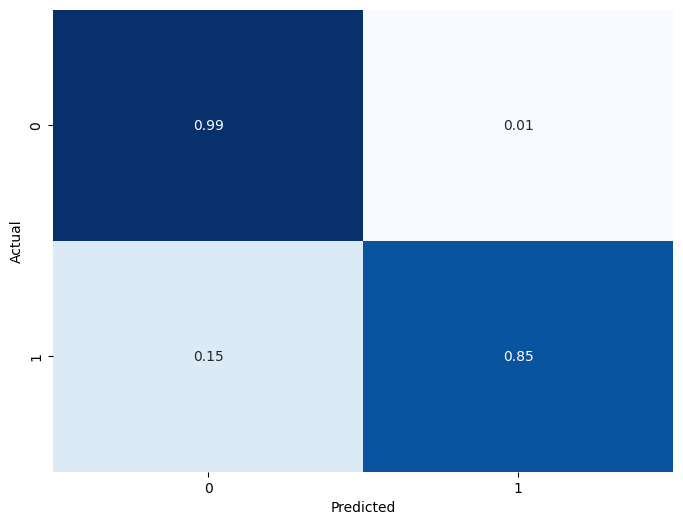

In [15]:
y_pred = model.predict(under_sampled_best_X_test)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# New Builder

In [16]:

def build_best_over_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_dim=n_best_over_features
    ))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_best_under_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory=output_dir,
    project_name='over_best_sel_shallow_nn'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

Reloading Tuner from ./shallow_nn_out/over_best_sel_shallow_nn/tuner0.json


## Over Sampling - Best selection

In [17]:
# training data
x_train = np.load(f'{base_dir}/over_sampled_best_X_train.npy')
y_train = np.load(f'{base_dir}/over_sampled_y_train.npy')
print("GPUS: ", tf.config.list_physical_devices('GPU'))

tuner.search(x_train, y_train, epochs=70, validation_data=(under_sampled_best_X_val, y_val), callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""Found:
- units: {best_hps.get('units')}
- activation: {best_hps.get('activation')}
- learning_rate: {best_hps.get('learning_rate')}
""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=70, validation_data=(under_sampled_best_X_val, y_val), callbacks=[early_stopping])

os.makedirs(f'{output_dir}/over_sampled_best_selection', exist_ok=True)
# Save the model
model.save(f'{output_dir}/over_sampled_best_selection/shallow_nn_model.h5')
# Save the history
with open(f'{output_dir}/over_sampled_best_selection/shallow_nn_history.json', 'w') as f:
    json.dump(history.history, f)

# Evaluate the model
test_loss, test_acc = model.evaluate(under_sampled_best_X_test, y_test)
#save the test loss and accuracy
with open(f'{output_dir}/over_sampled_best_selection/shallow_nn_test_loss_accuracy.txt', 'w') as f:
    f.write(f'Test loss: {test_loss}\nTest accuracy: {test_acc}\n')



GPUS:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found:
- units: 192
- activation: sigmoid
- learning_rate: 0.01

Epoch 1/70


/home/leikrad/Projects/TAA/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8086/8086 ━━━━━━━━━━━━━━━━━━━━ 7s 804us/step - accuracy: 0.9608 - loss: 0.1019 - val_accuracy: 0.9958 - val_loss: 0.0136
Epoch 2/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 761us/step - accuracy: 0.9980 - loss: 0.0085 - val_accuracy: 0.9975 - val_loss: 0.0107
Epoch 3/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 779us/step - accuracy: 0.9986 - loss: 0.0054 - val_accuracy: 0.9985 - val_loss: 0.0081
Epoch 4/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 779us/step - accuracy: 0.9990 - loss: 0.0042 - val_accuracy: 0.9986 - val_loss: 0.0073
Epoch 5/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 779us/step - accuracy: 0.9992 - loss: 0.0036 - val_accuracy: 0.9990 - val_loss: 0.0070
Epoch 6/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 780us/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 0.9987 - val_loss: 0.0086
Epoch 7/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 777us/step - accuracy: 0.9992 - loss: 0.0029 - val_accuracy: 0.9989 - val_loss: 0.0072
Epoch 8/70
8086/8086 ━━━━━━━━━━━━━━━━━━━━ 6s 774us/step - accuracy: 0.9993 - loss: 0.00

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 646us/step - accuracy: 0.9992 - loss: 0.0091


# Plot of Training and Validation Accuracy/Loss

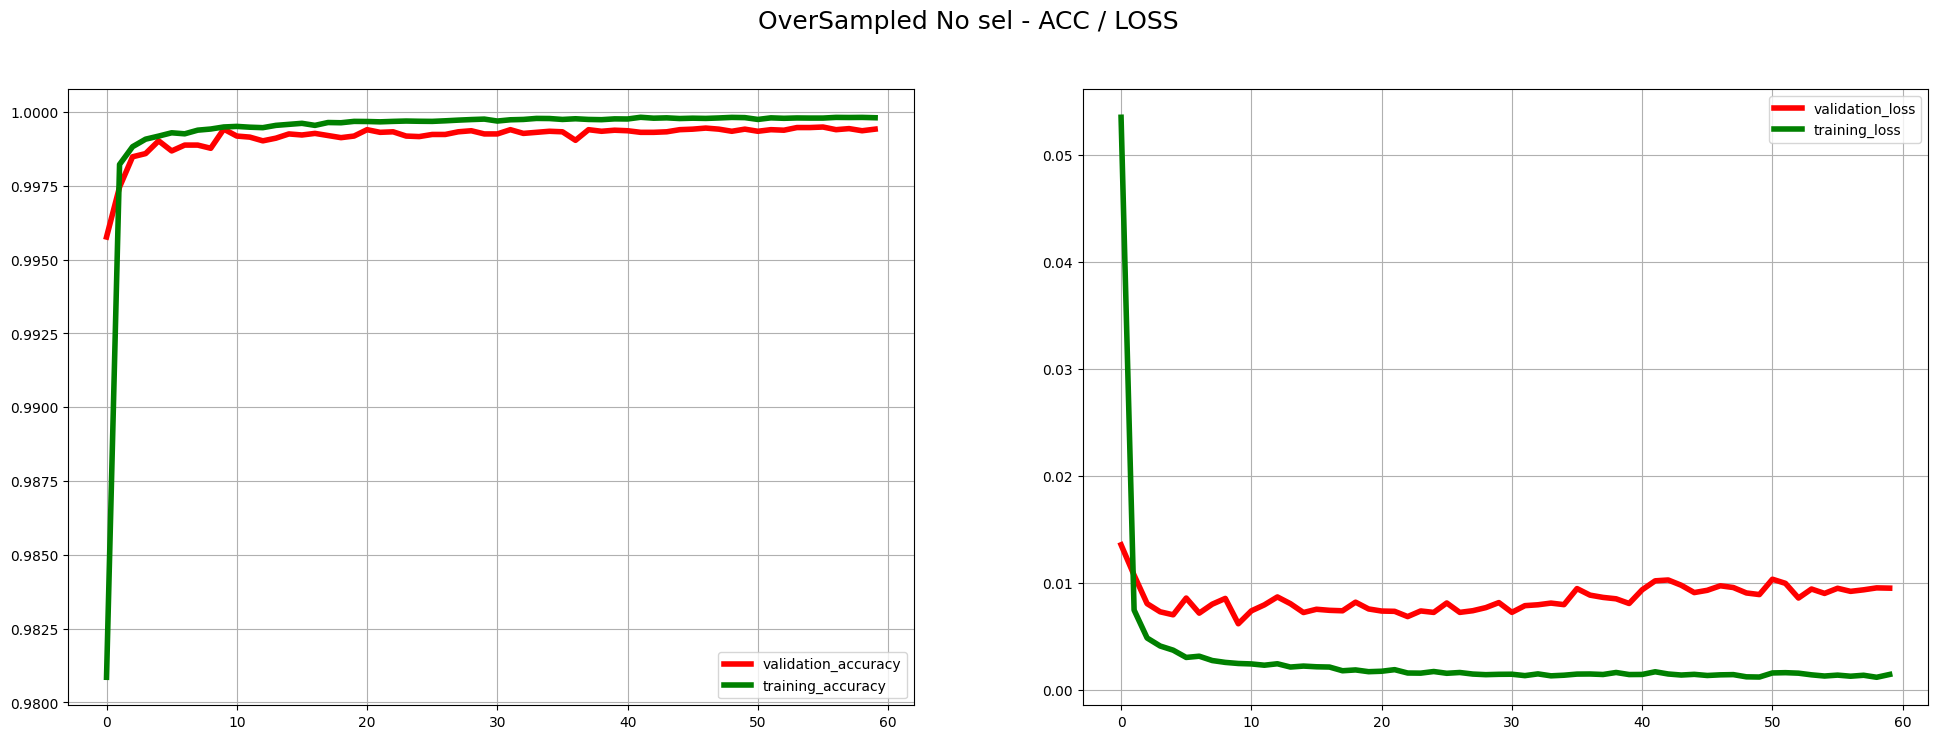

In [18]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(history.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(history.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(history.history["loss"],label="training_loss",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.suptitle("OverSampled No sel - ACC / LOSS",fontsize=18)

plt.show()

# Confusion Matrix

3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 545us/step
[[99455    56]
 [   36   136]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     99511
         1.0       0.71      0.79      0.75       172

    accuracy                           1.00     99683
   macro avg       0.85      0.90      0.87     99683
weighted avg       1.00      1.00      1.00     99683



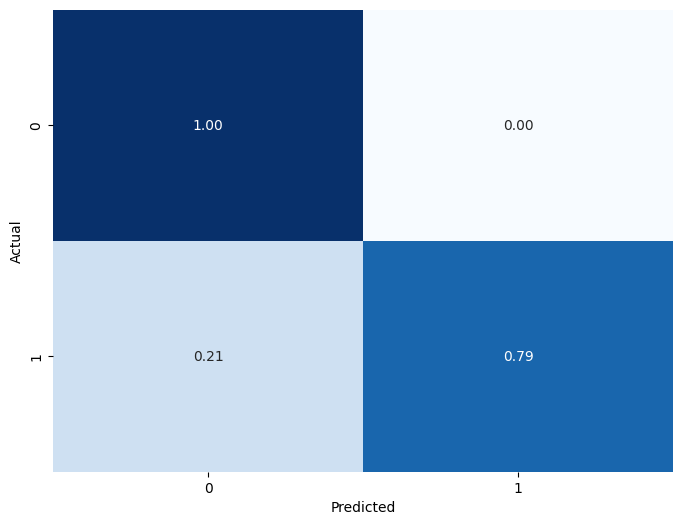

In [19]:
y_pred = model.predict(over_sampled_best_X_test)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()